## Задание:
Необходимо рассмотреть подготовленный список гипотез для увеличения выручки.

Приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты. 

**План работы:**
1. Приоритезация гипотез 
2. Ознокомление с данными 
3. Построение метрик 
4. Анализ А/В теста
5. Рекомендации для компании

In [1]:
#импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# 1. Приоритизация гипотез

In [2]:
hypothesis = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')

In [3]:
pd.options.display.max_colwidth = 100 #Увеличим количество символов, которые можно рассмотреть
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


## 1.1 Расчет ICE

In [4]:
ice_score = (hypothesis['Impact'] *  hypothesis['Confidence']) / hypothesis['Efforts']
ice_score.reset_index().sort_values(by=0, ascending=False)

,index,0
8,8,16.200000
0,0,13.333333
7,7,11.200000
6,6,8.000000
2,2,7.000000
1,1,2.000000
5,5,1.333333
3,3,1.125000
4,4,1.000000


При использовании ICE наиболее приоритетной гипотезой получилась 8 гипотеза: Запустить акцию, дающую скидку на товар в день рождения.  

In [5]:
rice_score = (hypothesis['Reach'] * hypothesis['Impact'] *  hypothesis['Confidence']) / hypothesis['Efforts']
rice_score.reset_index().sort_values(by=0, ascending=False)

,index,0
7,7,112.0
2,2,56.0
0,0,40.0
6,6,40.0
8,8,16.2
3,3,9.0
1,1,4.0
5,5,4.0
4,4,3.0


При использовании RICE наиболее приоритетной гипотезой получилась 7 гипотеза: Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок. 

**Вывод:**

При использовании различных способов приоритизации гипотез есть разница между гипотезами. При использовании ICE лучшей гипотезой является: Запустить акцию, дающую скидку на товар в день рождения. При использовании RICE лучшей гипотезой является: Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.

Таким образом, различие между ICE и RICE заключается в наличии параметра Reach в RICE, который учитывает масштаб изменений. RICE более полно оценивает потенциальное воздействие гипотезы на более широкую аудиторию, чем ICE.

# Часть 2. Анализ A/B-теста

## 1. Предобработка данных

### orders

In [6]:
orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv')
orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [7]:
orders.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [8]:
# Преобразуйте столбец 'date' в datetime
orders['date'] = pd.to_datetime(orders['date'])

In [9]:
orders.duplicated().sum() #рассмотрим количество дубликатов

0

**Вывод:**

Данные не содержат пропуски и дубликаты.

Даты привели к datetime.

### visitors

In [10]:
visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')

In [11]:
visitors

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


In [12]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [13]:
#Преобразуйте столбец 'date' в datetime
visitors['date'] = pd.to_datetime(visitors['date'])

In [14]:
visitors.duplicated().sum() #рассмотрим количество дубликатов

0

**Вывод:**

Данные не содержат пропуски и дубликаты.

Даты привели к datetime.

In [15]:
#Группировка данных по пользователям и подсчет количества групп для каждого пользователя
user_group_counts = orders.groupby('visitorId')['group'].nunique().reset_index()
user_group_counts

,visitorId,group
0,5114589,1
1,6958315,1
2,8300375,2
3,11685486,1
4,39475350,1
...,...,...
1026,4266935830,2
1027,4278982564,1
1028,4279090005,1
1029,4281247801,1


Есть пересекающиеся пользователи

In [16]:
visitors_intersect = set(orders[orders['group'] == 'A']['visitorId']) & set(orders[orders['visitorId'] == 'B']['visitorId'])
#пересекающиеся заказы
visitorsA = set(orders[(orders['group'] == 'A') & (orders['visitorId'].isin(visitors_intersect))]['transactionId'])
visitorsB = set(orders[(orders['group'] == 'B') & (orders['visitorId'].isin(visitors_intersect))]['transactionId'])
visitors_intersect = visitorsA.intersection(visitorsB)
visitors_intersect

set()

Но нет пересекающихся заказов

**Объеденим таблицы**

Создаем массив уникальных пар значений дат и групп теста

In [17]:
#используем метод drop_duplicates() для удаления дубликатов и отсортируем sort_values
datesGroups = orders[['date', 'group']].drop_duplicates().sort_values(by='date').reset_index()
datesGroups

,index,date,group
0,55,2019-08-01,A
1,66,2019-08-01,B
2,175,2019-08-02,A
3,173,2019-08-02,B
4,291,2019-08-03,A
...,...,...,...
57,497,2019-08-29,A
58,690,2019-08-30,B
59,730,2019-08-30,A
60,930,2019-08-31,B


In [18]:
#найдем агрегированные кумулятивные по дням данные о заказах
#для каждой группы и даты из datesGroups выбираем соответствующие строки из orders и применяем агрегирующие функции для каждой группы и даты
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= 
x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 
'transactionId': pd.Series.nunique, 'visitorId' : pd.Series.nunique, 'revenue' : 'sum'}), 
axis=1).sort_values(by=['date','group'])
ordersAggregated

,date,group,transactionId,visitorId,revenue
0,2019-08-01,A,24,20,148579
1,2019-08-01,B,21,20,101217
2,2019-08-02,A,44,38,242401
3,2019-08-02,B,45,43,266748
4,2019-08-03,A,68,62,354874
...,...,...,...,...,...
56,2019-08-29,B,596,544,5559398
59,2019-08-30,A,545,493,4022970
58,2019-08-30,B,620,567,5774631
61,2019-08-31,A,557,503,4084803


In [19]:
#получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] 
<= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 
'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])
visitorsAggregated

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-01,B,713
2,2019-08-02,A,1338
3,2019-08-02,B,1294
4,2019-08-03,A,1845
...,...,...,...
56,2019-08-29,B,17708
59,2019-08-30,A,18037
58,2019-08-30,B,18198
61,2019-08-31,A,18736


Данные за один месяц

In [20]:
# объединяем кумулятивные данные в одной таблице 
cummulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], 
right_on=['date', 'group'])

#переименуем столбцы в cummulativeData
cummulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cummulativeData

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845
...,...,...,...,...,...,...
57,2019-08-29,B,596,544,5559398,17708
58,2019-08-30,A,545,493,4022970,18037
59,2019-08-30,B,620,567,5774631,18198
60,2019-08-31,A,557,503,4084803,18736


Проверим таблицу на пропуски и дубликаты 

In [21]:
cummulativeData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62 entries, 0 to 61
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   orders    62 non-null     int64         
 3   buyers    62 non-null     int64         
 4   revenue   62 non-null     int64         
 5   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 3.4+ KB


In [22]:
cummulativeData.duplicated().sum()

0

In [23]:
cummulativeData.isna().sum()

date        0
group       0
orders      0
buyers      0
revenue     0
visitors    0
dtype: int64

**Вывод:**

Объеденили таблицы и получили агрегированные кумулятивные по дням данные о заказах и посетителях

Объедененные данные не содержат пропуски и дубликаты

## 2. Построение графиков 

**График кумулятивной выручки по группам**

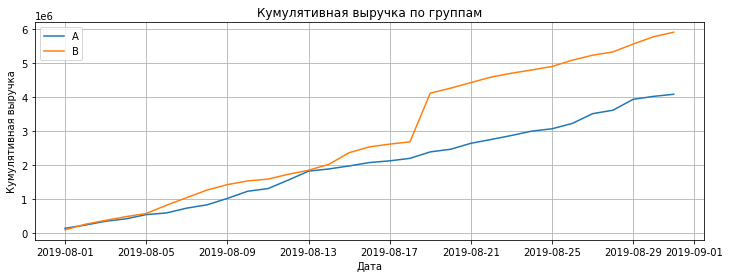

In [24]:
# Создаем датафрейм с кумулятивной выручкой по дням в группе A и B
cumulativeRevenueA = cummulativeData[cummulativeData['group'] == 'A'] 
cumulativeRevenueB = cummulativeData[cummulativeData['group'] == 'B'] 

# Строим график кумулятивной выручки группы A и B
plt.figure(figsize=(12, 4))
plt.grid()
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Кумулятивная выручка')
plt.title('Кумулятивная выручка по группам')
plt.show()

Выручка почти равномерно увеличивается в течение всего теста. В группе B 18 августа происходит резкий скачек, что связано либо с увеличением числа заказов, либо с более дорогим заказом. 

**График кумулятивного среднего чека по группам**

Разделим кумулятивную выручку на кумулятивное число заказов

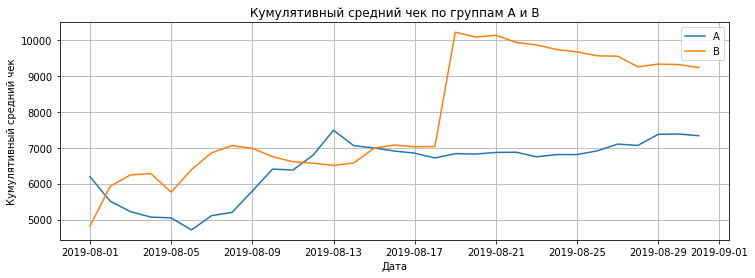

In [25]:
#Строим графики кумулятивного среднего чека для групп A и B
plt.figure(figsize=(12, 4))
plt.grid()
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'] / cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'] / cumulativeRevenueB['orders'], label='B')
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Кумулятивный средний чек')
plt.title('Кумулятивный средний чек по группам A и B')
plt.show()

Средний чек выглядит не так стабильно на протяжении всего периода, но растет для обоих групп. Для группы В после скачка 18.08 и мы видим стабилизацию среднего чека и постепенное снижение на новом уровне около 9-10 тыс. Для группы А средний чек стабилизируется после 13.08 на уровне 7000. Необходимо найти крупные заказы. 

**График относительного изменения кумулятивного среднего чека группы B к группе A** 

In [26]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', 
                                                   how='left', suffixes=['A', 'B'])

mergedCumulativeRevenue

,date,groupA,ordersA,buyersA,revenueA,visitorsA,groupB,ordersB,buyersB,revenueB,visitorsB
0,2019-08-01,A,24,20,148579,719,B,21,20,101217,713
1,2019-08-02,A,44,38,242401,1338,B,45,43,266748,1294
2,2019-08-03,A,68,62,354874,1845,B,61,59,380996,1803
3,2019-08-04,A,84,77,425699,2562,B,78,75,489567,2573
4,2019-08-05,A,109,100,549917,3318,B,101,98,581995,3280
5,2019-08-06,A,127,114,598401,3985,B,129,123,824337,3935
6,2019-08-07,A,145,131,740818,4629,B,153,146,1049671,4644
7,2019-08-08,A,161,146,837097,5239,B,180,171,1270589,5298
8,2019-08-09,A,177,159,1025603,5856,B,205,193,1431401,5908
9,2019-08-10,A,193,175,1236098,6262,B,228,215,1539203,6277


In [27]:
#рарсчитаем относительное изменение кумулятивного среднего чека группы B к группе A
n = (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1

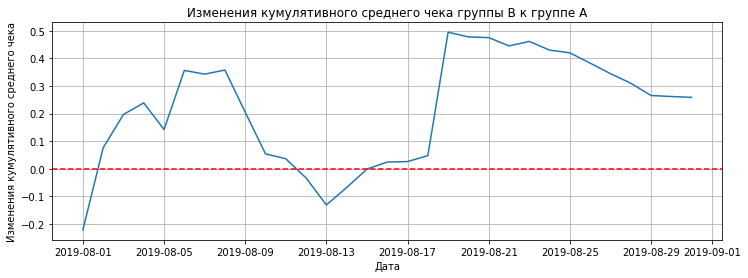

In [28]:
# Строим график относительного изменения кумулятивного среднего чека группы B к группе A
plt.figure(figsize=(12, 4))
plt.grid()
plt.plot(mergedCumulativeRevenue['date'], n)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Дата')
plt.ylabel('Изменения кумулятивного среднего чека')
plt.title('Изменения кумулятивного среднего чека группы B к группе A')
plt.show()

График изменения кумулятивного среднего чека скачет и резко изменяется, что также подтверждает наличие в данных крупных заказов.

**График кумулятивного среднего количества заказов на посетителя по группам**

In [29]:
#считаем кумулятивную конверсию
cummulativeData['conversion'] = cummulativeData['orders']/cummulativeData['visitors']
#разделим данные по группам
cumulativeDataA = cummulativeData[cummulativeData['group']=='A']
cumulativeDataB = cummulativeData[cummulativeData['group']=='B']

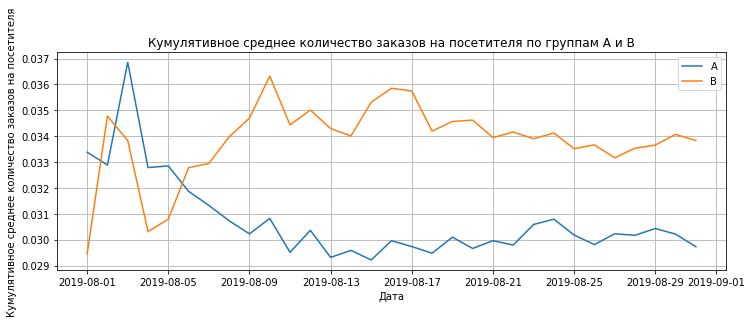

In [30]:
#график кумулятивного среднего количества заказов на посетителя для групп A и B 
plt.figure(figsize=(12, 4))
plt.grid()
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Кумулятивное среднее количество заказов на посетителя')
plt.title('Кумулятивное среднее количество заказов на посетителя по группам A и B')
plt.show()

На графике видно, что показатель кумулятивного среднго количества заказов на посетителя стабилизировался после 09.08. Также показатель для тестовой группы выше, чем для контрольной.

Для начала теста характерны колебания, к середине теста показатели стабилизировались.

**График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A**

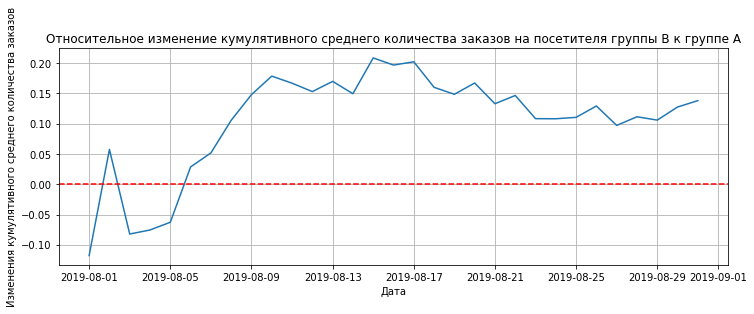

In [31]:
# Строим график относительного изменения кумулятивного среднего чека группы B к группе A
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], 
                                                                           left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(12, 4))
plt.grid()
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB'] / mergedCumulativeConversions['conversionA']-1)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Дата')
plt.ylabel('Изменения кумулятивного среднего количества заказов')
plt.title('Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.show()

Почти весь период наблюдения группа В была лучше.

Относительное изменение кумулятивного среднего количества заказов на посетителя для группы В постепенно увеличилось для группы А после 05.08. Показатель конверсии стабилизировался на новом уровне в положительной зоне.  

**Точечный график количества заказов по пользователям**

In [32]:
#количество заказов на одного пользователя
orders_per_user = orders.groupby('visitorId')['transactionId'].count().reset_index()
orders_per_user

,visitorId,transactionId
0,5114589,1
1,6958315,1
2,8300375,2
3,11685486,1
4,39475350,1
...,...,...
1026,4266935830,2
1027,4278982564,1
1028,4279090005,1
1029,4281247801,1


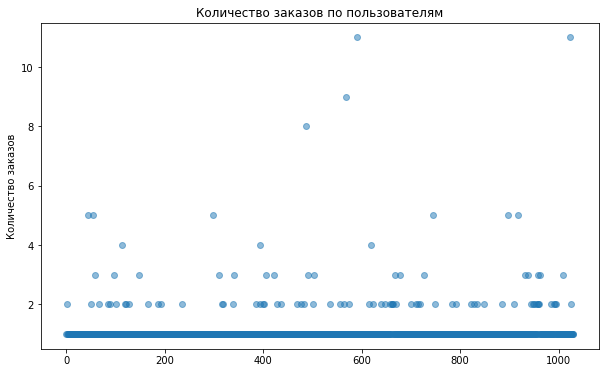

In [33]:
# Создаем точечный график
plt.figure(figsize=(10, 6))
plt.scatter(orders_per_user.index, orders_per_user['transactionId'], alpha=0.5)
plt.title('Количество заказов по пользователям')
plt.ylabel('Количество заказов')
plt.show()

На графике мы видим, что данные содержат выбросы и есть несколько пользователей, которые совершили аномально большое количество заказов в сравнении с другими пользователями. Рассмотрим данные о количестве заказов на одного пользователя более детально ниже.

**95-й и 99-й перцентили количества заказов на пользователя** 

Выберите границу для определения аномальных пользователей.

In [34]:
orders_per_user['transactionId'].describe()

count    1031.000000
mean        1.161009
std         0.724919
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        11.000000
Name: transactionId, dtype: float64

In [35]:
orders_per_user['transactionId'].value_counts()

1     937
2      64
3      17
5       6
4       3
11      2
8       1
9       1
Name: transactionId, dtype: int64

Цифры подтверждают данные на графике. Выбросов не много, но они есть. Среднее не сильно отличается от медианы, а и стандартное отклонение не выглядит большим. 
Максимально кол-во заказов на одного пользователя 11, а наболее популярное 1 заказ на одного пользователя.

<AxesSubplot:>

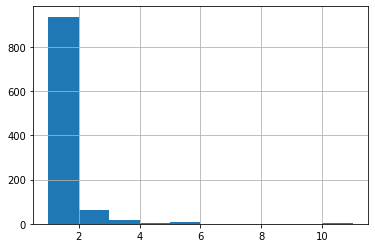

In [36]:
orders_per_user['transactionId'].hist()

In [37]:
#вычислим перцентили 
(np.percentile(orders_per_user['transactionId'], [90, 95, 97.5, 99])) 

array([1., 2., 3., 4.])

Отфильтруем данные, отрезав выбросы по 99 перцентилю. Выберем границу для определения аномальных заказов

In [38]:
#отфильтруем данные 
filtered = orders_per_user[orders_per_user['transactionId'] < 4]
filtered

,visitorId,transactionId
0,5114589,1
1,6958315,1
2,8300375,2
3,11685486,1
4,39475350,1
...,...,...
1026,4266935830,2
1027,4278982564,1
1028,4279090005,1
1029,4281247801,1


**Точечный график стоимостей заказов**

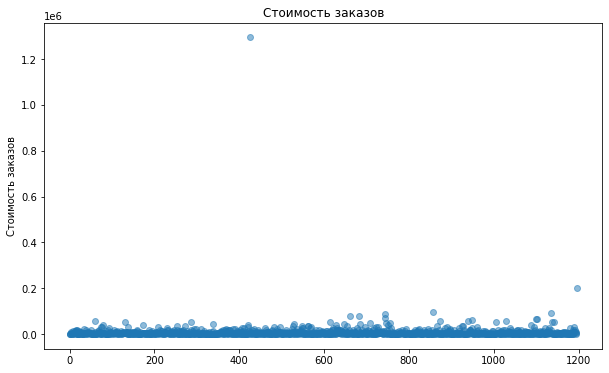

In [39]:
# Создаем точечный график
plt.figure(figsize=(10, 6))
plt.scatter(orders.index, orders['revenue'], alpha=0.5)
plt.title('Стоимость заказов')
#plt.xlabel('Пользователь')
plt.ylabel('Стоимость заказов')
plt.show()

Точно также в данных по стоимости заказов есть выбросы, которые необходимо рассмотреть более детально

**Посчитайте 95-й и 99-й перцентили стоимости заказов**

In [40]:
orders['revenue'].describe()

count    1.197000e+03
mean     8.348006e+03
std      3.919113e+04
min      5.000000e+01
25%      1.220000e+03
50%      2.978000e+03
75%      8.290000e+03
max      1.294500e+06
Name: revenue, dtype: float64

Данные содержат выбросы. Среднее значение сильно отличается от медианного. Также в данных большой разброс на что указывает высокое значение стандартного отклонения. 

<AxesSubplot:>

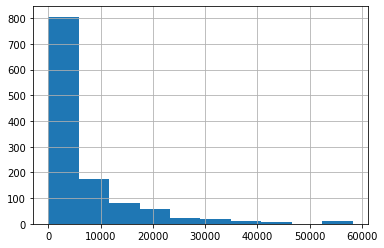

In [41]:
orders['revenue'].hist(range=(0,58233))

In [42]:
# Рассмотрим значения на разных перцентилей и выберем границу для определения аномальных заказов
(orders['revenue']
    .quantile([.95,.96,.97,.98,.99])
)

0.95    28000.0
0.96    31382.0
0.97    35485.0
0.98    44133.2
0.99    58233.2
Name: revenue, dtype: float64

Отфильтруем данные отчистив от выбросов по 99 перцентилю в 58 тыс. 

In [43]:
#фильтруем данные
percentile_revenue = np.percentile(orders['revenue'], 99)
filtered_revenue = orders[orders['revenue'] < percentile_revenue]
filtered_revenue

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,16490,B
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A


**Отфильтруем сырые данные для дальнейшего анализа**

In [44]:
#объеденим filtered и filtered_revenue и получим отфильтрованные данные
filtered_data = filtered_revenue.merge(filtered, on='visitorId', how='inner')
filtered_data

,transactionId_x,visitorId,date,revenue,group,transactionId_y
0,3667963787,3312258926,2019-08-15,1650,B,1
1,2804400009,3642806036,2019-08-15,730,B,1
2,2961555356,4069496402,2019-08-15,400,A,2
3,1473132782,4069496402,2019-08-12,640,B,2
4,3797467345,1196621759,2019-08-15,9759,B,1
...,...,...,...,...,...,...
1099,38478481,1197745035,2019-08-14,8600,B,1
1100,3592955527,608641596,2019-08-14,16490,B,1
1101,2662137336,3733762160,2019-08-14,6490,B,1
1102,2203539145,370388673,2019-08-14,3190,A,1


Проферим filtered_data 

In [45]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1104 entries, 0 to 1103
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   transactionId_x  1104 non-null   int64         
 1   visitorId        1104 non-null   int64         
 2   date             1104 non-null   datetime64[ns]
 3   revenue          1104 non-null   int64         
 4   group            1104 non-null   object        
 5   transactionId_y  1104 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 60.4+ KB


In [46]:
filtered_data.duplicated().sum()

0

In [47]:
filtered_data['transactionId_y'].describe()

count    1104.000000
mean        1.205616
std         0.505926
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: transactionId_y, dtype: float64

In [48]:
filtered_data['revenue'].describe()

count     1104.000000
mean      6468.140399
std       8723.756547
min         50.000000
25%       1190.000000
50%       2955.000000
75%       8022.500000
max      53904.000000
Name: revenue, dtype: float64

In [49]:
#переименуем названия столбцов
filtered_data.columns = ['transactionId', 'visitorId', 'date', 'revenue', 'group', 'transaction_count'] 
filtered_data

,transactionId,visitorId,date,revenue,group,transaction_count
0,3667963787,3312258926,2019-08-15,1650,B,1
1,2804400009,3642806036,2019-08-15,730,B,1
2,2961555356,4069496402,2019-08-15,400,A,2
3,1473132782,4069496402,2019-08-12,640,B,2
4,3797467345,1196621759,2019-08-15,9759,B,1
...,...,...,...,...,...,...
1099,38478481,1197745035,2019-08-14,8600,B,1
1100,3592955527,608641596,2019-08-14,16490,B,1
1101,2662137336,3733762160,2019-08-14,6490,B,1
1102,2203539145,370388673,2019-08-14,3190,A,1


Новый датафрейм не содержит выбросов, пропусков и дубликатов

**Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.**

Создадим выборку с количеством заказов для пользователей в группе A и добавим нули для тех пользователей, которые не сделали заказов

In [50]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']
ordersByUsersA

,visitorId,orders
0,8300375,1
1,11685486,1
2,54447517,1
3,66685450,1
4,78758296,1
...,...,...
498,4243832526,1
499,4256040402,7
500,4259830713,1
501,4266935830,1


In [51]:
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index = np.arange(
                cummulativeData[cummulativeData['group'] == 'A']['visitors'].max() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
sampleA

0        1
1        1
2        1
3        1
4        1
        ..
18228    0
18229    0
18230    0
18231    0
18232    0
Name: orders, Length: 18736, dtype: int64

Тоже самое сделаем для пользователей в группе В

In [52]:
ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']
ordersByUsersB

,visitorId,orders
0,5114589,1
1,6958315,1
2,8300375,1
3,39475350,1
4,47206413,1
...,...,...
581,4258103007,1
582,4266935830,1
583,4279090005,1
584,4281247801,1


In [53]:
sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index = np.arange(
                cummulativeData[cummulativeData['group'] == 'B']['visitors'].max() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
sampleB

0        1
1        1
2        1
3        1
4        1
        ..
18325    0
18326    0
18327    0
18328    0
18329    0
Name: orders, Length: 18916, dtype: int64

Проверим какие значения получились

In [54]:
sampleA.value_counts() 

0    18233
1      473
2       17
3        7
4        3
5        2
7        1
Name: orders, dtype: int64

In [55]:
sampleB.value_counts()

0    18330
1      552
2       23
3        5
4        4
5        1
6        1
Name: orders, dtype: int64

Так как данные о количестве заказов не распределены нормально нам необходимо использовать непараметррический тест. Для сравнения двух независимых выборок и определения, есть ли статистически значимые различия между ними мы будем использовать статистический тест Манна-Уитни.

Поэтому для проверки статистической значимости различий в среднем количестве заказов на посетителя будем использовать статистический тест Манна-Уитни.

Н0: среднее значение количества заказов на посетителя для группы A и группы B равны.

H1: средние значения количества заказов на посетителя для группы A и группы B различаются.

In [56]:
#статистический тест Манна-Уитни
results = stats.mannwhitneyu(sampleA, sampleB)
#Получение p-value
p_value = results.pvalue
print('p-value: {}'.format(p_value))
# Оценка статистической значимости
alpha = 0.05
if p_value < alpha:
    print("Есть статистически значимые различия между группами.")
else:
    print("Нет статистически значимых различий между группами.")

p-value: 0.016792355056752608
Есть статистически значимые различия между группами.


Значение P-value низкое и меньше уровня значимости. Это указывает на то, что существует статистически значимая разница между группами по среднему количеству заказов на посетителя. А маленькое значение P-value указывает на то, что вероятность получить такие различия случайно крайне мала. Этот различия в конверсии между группами (в пользу группы В) мы наблюдали и на графике ранее.

In [57]:
sampleB.mean()/sampleA.mean()- 1

0.13807884655320146

Относительный прирост конверсии группы B над группой A составил 13.8%

**Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.**

По тем же причинам, как и в прошлом тесте, мы будем использовать статистический тест Манна-Уитни.

Н0: средние чеки заказа равны для группы A и группы B.

H1: средние чеки заказа различаются между группой A и группой B.

In [58]:
#сформируем группы
average_sampleA = orders[orders['group']=='A']['revenue']
average_sampleB = orders[orders['group']=='B']['revenue']

In [59]:
#статистический тест Манна-Уитни
results = stats.mannwhitneyu(average_sampleA, average_sampleB)
# Получение p-value
p_value = results.pvalue
print('p-value: {}'.format(p_value))
# Оценка статистической значимости
alpha = 0.05
if p_value < alpha:
    print("Есть статистически значимые различия между группами.")
else:
    print("Нет статистически значимых различий между группами.")

p-value: 0.7292909855432458
Нет статистически значимых различий между группами.


Не можем отвергнуть нулевую гипотезу, так как P-value значительно больше уровня значимости, а разница между выборками имеет случайный характер. Это указывает на остутствие наличия статистически значимых различий между группами по среднему чеку заказа. 

**Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.**

Подготовим отфильтрованные данные также, как уже делали ранее с сырыми.

In [60]:
filtered_datesGroups = filtered_data[['date', 'group']].drop_duplicates().sort_values(by='date').reset_index()
filtered_datesGroups
# получаем агрегированные кумулятивные по дням данные о заказах 
filtered_ordersAggregated = filtered_datesGroups.apply(lambda x: filtered_data[np.logical_and(filtered_data['date'] <= 
x['date'], filtered_data['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 
'transactionId': pd.Series.nunique, 'visitorId' : pd.Series.nunique, 'revenue' : 'sum'}), 
axis=1).sort_values(by=['date','group'])
filtered_ordersAggregated
# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
filtered_visitorsAggregated = filtered_datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] 
<= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 
'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])
filtered_visitorsAggregated
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
filtered_cummulativeData = filtered_ordersAggregated.merge(filtered_visitorsAggregated, left_on=['date', 'group'], 
right_on=['date', 'group'])
filtered_cummulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
filtered_cummulativeData


,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,19,19,78258,713
2,2019-08-02,A,43,37,236601,1338
3,2019-08-02,B,42,41,240301,1294
4,2019-08-03,A,67,61,349074,1845
...,...,...,...,...,...,...
57,2019-08-29,B,551,526,3458183,17708
58,2019-08-30,A,499,473,3279469,18037
59,2019-08-30,B,575,549,3673416,18198
60,2019-08-31,A,510,483,3336132,18736


In [61]:
filtered_cummulativeData.info() #check

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62 entries, 0 to 61
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   orders    62 non-null     int64         
 3   buyers    62 non-null     int64         
 4   revenue   62 non-null     int64         
 5   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 3.4+ KB


In [62]:
cummulativeData['orders'].describe() #check

count     62.000000
mean     317.661290
std      172.828157
min       21.000000
25%      177.750000
50%      319.500000
75%      459.250000
max      640.000000
Name: orders, dtype: float64

In [63]:
filtered_cummulativeData['orders'].describe() #check

count     62.000000
mean     292.822581
std      158.407497
min       19.000000
25%      166.000000
50%      291.500000
75%      423.000000
max      594.000000
Name: orders, dtype: float64

**Создаем группы с отфильтрованными данными**

Создадим выборку по отчищенным данным с количеством заказов для пользователей в группе A и добавим нули для тех пользователей, которые не сделали заказов

In [64]:
filtered_ordersByUsersA = (
    filtered_data[filtered_data['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
filtered_ordersByUsersA.columns = ['visitorId', 'orders']
filtered_ordersByUsersA

,visitorId,orders
0,8300375,1
1,11685486,1
2,54447517,1
3,66685450,1
4,78758296,1
...,...,...
478,4227830084,1
479,4237561104,1
480,4243832526,1
481,4259830713,1


In [65]:
filtered_sampleA = pd.concat([filtered_ordersByUsersA['orders'],
        pd.Series(0,index = np.arange(
        filtered_cummulativeData[filtered_cummulativeData['group'] == 'A']['visitors'].max() - len(filtered_ordersByUsersA['orders'])
            ),name='orders',),],axis=0,)
filtered_sampleA

0        1
1        1
2        1
3        1
4        1
        ..
18248    0
18249    0
18250    0
18251    0
18252    0
Name: orders, Length: 18736, dtype: int64

In [66]:
filtered_sampleA.value_counts()

0    18253
1      461
2       17
3        5
Name: orders, dtype: int64

Тоже самое сделаем для группы В

In [67]:
filtered_ordersByUsersB = (
    filtered_data[filtered_data['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
filtered_ordersByUsersB.columns = ['visitorId', 'orders']
filtered_ordersByUsersB

,visitorId,orders
0,5114589,1
1,6958315,1
2,8300375,1
3,39475350,1
4,47206413,1
...,...,...
563,4251115836,1
564,4258103007,1
565,4279090005,1
566,4281247801,1


In [68]:
filtered_sampleB = pd.concat(
    [
        filtered_ordersByUsersB['orders'],
        pd.Series(
            0,
            index = np.arange(
                filtered_cummulativeData[filtered_cummulativeData['group'] == 'B']['visitors'].max() - len(filtered_ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
filtered_sampleB

0        1
1        1
2        1
3        1
4        1
        ..
18428    0
18429    0
18430    0
18431    0
18432    0
Name: orders, Length: 19001, dtype: int64

In [69]:
filtered_sampleB.value_counts()

0    18433
1      544
2       22
3        2
Name: orders, dtype: int64

Приступим к выполнению тест Манна-Уитни по отфильтрованным данным, так как данные даже после отчистки не имеют нормального распределения. 

Н0: средние значения количества заказов на посетителя для группы A и группы B равны.

Н1: средние значения количества заказов на посетителя для группы A и группы B различаются.

In [70]:
results = stats.mannwhitneyu(filtered_sampleA, filtered_sampleB)
# Получение p-value
p_value = results.pvalue
print('p-value: {}'.format(p_value))
# Оценка статистической значимости
alpha = 0.05
if p_value < alpha:
    print("Есть статистически значимые различия между группами.")
else:
    print("Нет статистически значимых различий между группами.")

p-value: 0.01523824923151815
Есть статистически значимые различия между группами.


Также отвергаем нулевую гипотезу. Есть статистически значимые различия между группами и среднее количестве заказов на посетителя в группе В выше.

По результатам теста на отфильтрованных данных отвергаем нулевую гипотезу, так как между нашими группами на отфильтрованных данных есть статистически значимые различия между группами

In [71]:
filtered_sampleB.mean()/filtered_sampleA.mean()- 1

0.1484621552426033

Относительный прирост конверсии группы B равен 14.8% и не сильно отличаются от результатов по отфильтрованым данным

**Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.**

Выполнению тест Манна-Уитни по отфильтрованным данным для среднего чека в заказе между группами 

Н0: средние чеки заказа равны для группы A и группы B.

Н1: средние чеки заказа различаются между группой A и группой B.

In [72]:
#сформируем группы
filtered_average_sampleA = filtered_data[filtered_data['group']=='A']['revenue']
filtered_average_sampleB = filtered_data[filtered_data['group']=='B']['revenue']

In [73]:
results = stats.mannwhitneyu(filtered_average_sampleA, filtered_average_sampleB)
# Получение p-value
p_value = results.pvalue
print('p-value: {}'.format(p_value))
# Оценка статистической значимости
alpha = 0.05
if p_value < alpha:
    print("Есть статистически значимые различия между группами.")
else:
    print("Нет статистически значимых различий между группами.")

p-value: 0.8803522991088097
Нет статистически значимых различий между группами.


По результатм теста не удалось отвергнуть нулевую гипотезу и фильтрация никак не изменила ситуацию. Это указывает на отсутствие статистически значимых различий между группами по среднему чеку заказа. 

**Вывод**
1. При использовании различных способов приоритизации гипотез есть разница между гипотезами. При использовании RICE наиболее приоритетная гипотеза: добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок. При использовании ICE наиболее приоритетная гипотеза: запустить акцию, дающую скидку на товар в день рождения. Различие между ICE и RICE заключается в наличии параметра Reach в RICE, который учитывает масштаб изменений. RICE более полно оценивает потенциальное воздействие гипотезы на более широкую аудиторию, чем ICE.
2. Существует статистически значимая разница между группами по среднему количеству заказов на посетителя как для сырых, так и для отфильтрованных даннх. Этот различия в конверсии между группами (в пользу группы В) мы также наблюдаем на графике. Относительный прирост конверсии группы B равен 14.8% по отчищенным данным и не сильно отличаются от результатов по отфильтрованым данным
3. По результатм теста не удалось отвергнуть нулевую гипотезу для данных до и после фильтрации. Это указывает на отсутствие статистически значимых различий между группами по среднему чеку заказа. Хотя график различия среднего чека колеблется и к концу периода наблюдения тоже показывает, что результаты группы B становятся лучше группы A.
4. Я думаю, что правльным решением будет закончить тест, потому что метрики среднего количестве заказов и среднего чека уже стабилизировались, а статистические тесты показали, что статистические различия между группами есть. 




Среднее количество заказов увеличилось при отсутствии значимых изменений по среднему чеку -> выручка увеличилась, так как стали покупать чаще.